# Example MLP: Data base Iris

In this example it will show how to work the library **libml**. 

## Data

This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. 

- Predicted attribute: class of iris plant.
- Number of Instances: 150
- Number of Attributes: 4

This data differs from the data presented in Fishers article (identified by Steve Chadwick, <spchadwick@espeedaz.net>). The 35th sample should be: 4.9,3.1,1.5,0.2,"Iris-setosa" where the error is in the fourth feature. The 38th sample: 4.9,3.6,1.4,0.1,"Iris-setosa" where the errors are in the second and third features.

In [1]:
import theano
import theano.tensor as T
import numpy as np
from sklearn.datasets import load_iris
from theano.sandbox import cuda

theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

iris = load_iris()

data_input    = np.asarray(iris.data, dtype=theano.config.floatX)
data_target   = iris.target_names[iris.target]
classes_names = iris.target_names

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


## Training MLP

The arquitecture of MLP net is a 3 neurons in hidden layer and the output is a vector with 3 elements that represent each class (**one hot encoding**). The cost function is **MSE** and the uupdate funtion is **ADAGRAD**. The 60% of data set it's used for the training set and 40% in the testing set.

#### Important: the library libml must be installed.

In [2]:
import time
from libml.models.sequential import Sequential
from libml.layers.dense import Dense
from libml.utils.cost_functions import *
from libml.utils.update_functions import *
from libml.utils.regularizer_functions import *
from sklearn import cross_validation

net1 = Sequential(classes_names, "classifier", name="net1")
net1.add_layer(Dense(n_input=data_input.shape[1], n_output=3, activation=T.tanh))
net1.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.softmax))
net1.append_cost(mse)
net1.append_reg(L1, lamb=0.005)
net1.append_reg(L2, lamb=0.001)
net1.set_update(adagrad, initial_learning_rate=0.15)
net1.compile()

max_epoch = 400
validation_jump = 5

input_train, input_test, target_train, target_test = cross_validation.train_test_split(
        data_input, data_target, test_size=0.4, random_state=0)

tic = time.time()
metrics = net1.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
toc = time.time()
# Compute metrics
metrics.append_prediction(target_test, net1.predict(input_test))
print("Elapsed time: %f [s]" % (toc - tic))
print("Training net1 ended!")

Elapsed time: 1.020265 [s]
Training net1 ended!


## Results

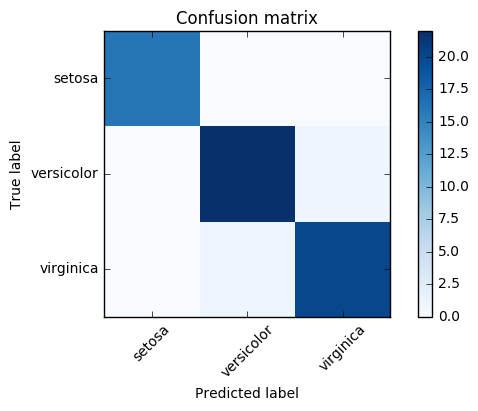

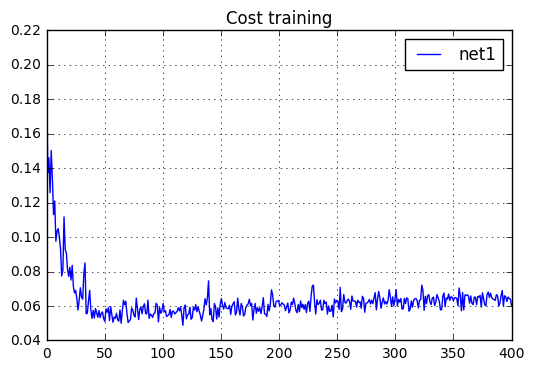

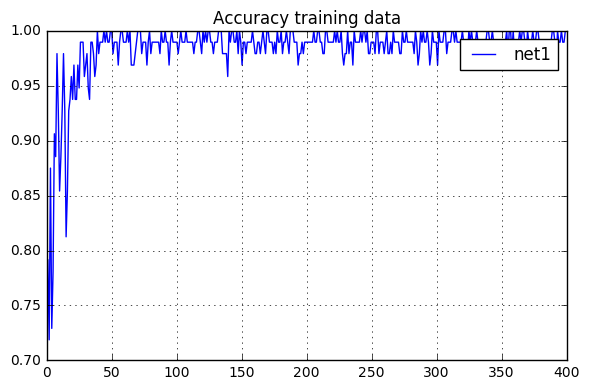

In [3]:
%matplotlib inline
import matplotlib.pylab as plt

metrics.plot_confusion_matrix()
metrics.plot_cost(max_epoch, "Cost training")
metrics.plot_score(max_epoch, "Accuracy training data")

plt.tight_layout()